In [3]:
# Uncomment to install `sklearn-pandas`
! pip install sklearn-pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df_train = pd.read_csv("E:/DATN_LVTN/SA/with_image/primary_method/DeepSurv/processed_data.csv")
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_train.head()

,Age,Weight (lbs),Gender,Ethnicity,Smoking status,%GG,Tumor Location (choice=RUL),Tumor Location (choice=RML),Tumor Location (choice=RLL),Tumor Location (choice=LUL),...,Std,Min,Max,Median,SurfaceArea,Elongation,Flatness,Roundness,Time to Event,Event
1,65,195.0,0,1,2,0,0,1,1,1,...,173.439744,-829,144,-36.021484,1037.374063,1.367921,1.112439,0.781205,70,0
2,65,173.5,1,2,0,0,1,1,1,1,...,172.357348,-815,290,23.177734,755.268235,1.387373,1.089084,0.822009,666,0
3,67,173.5,1,2,1,0,1,1,1,0,...,254.147443,-1024,366,21.595703,912.514223,1.593605,1.631120,0.639694,1172,0
4,84,145.0,1,4,1,0,1,0,1,1,...,107.583454,-783,391,7.496094,2432.305090,1.278080,1.166290,0.735654,1456,1
5,62,173.5,1,2,1,0,1,1,1,0,...,202.738563,-844,88,-103.359375,1982.069341,1.242244,1.341162,0.635347,2297,0


In [4]:
cols_standardize = ['Age', 'Weight (lbs)', 'Ethnicity', 'Smoking status', '%GG', 'Histology', 'Pathological T stage', 'Pathological N stage', 'Pathological M stage', 
                    'Histopathological Grade', 'Lymphovascular invasion', 'EGFR mutation status', 'KRAS mutation status', 'ALK translocation status', 'Days between CT and surgery',
                    'Volume', 'Mean', 'Min', 'Max', 'Std', 'SurfaceArea', 'Elongation', 'Flatness', 'Roundness']
cols_leave = ['Tumor Location (choice=RUL)', 'Tumor Location (choice=RML)', 'Tumor Location (choice=RLL)', 'Tumor Location (choice=LUL)', 'Tumor Location (choice=LLL)',
              'Pleural invasion (elastic, visceral, or parietal)', 'Adjuvant Treatment', 'Chemotherapy', 'Radiation', 'Recurrence']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [5]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [6]:
get_target = lambda df: (df['Time to Event'].values, df['Event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [7]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [8]:
model = CoxPH(net, tt.optim.Adam)

c:\Users\ADMIN\anaconda3\envs\DATN\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwarg

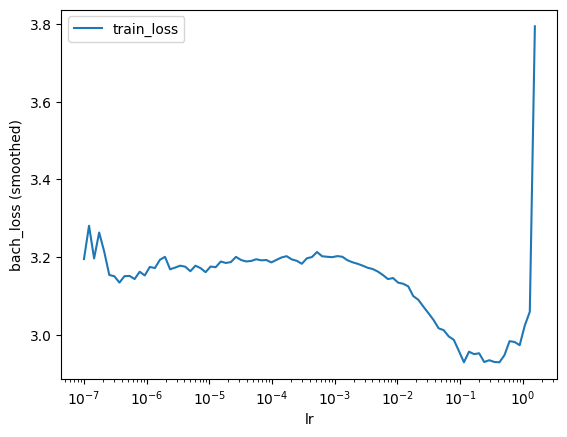

In [9]:
batch_size = 32
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [10]:
lrfinder.get_best_lr()

0.04229242874389523

In [11]:
model.optimizer.set_lr(0.01)

In [12]:
epochs = 500
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [13]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.2183,	val_loss: 2.8914
1:	[0s / 0s],		train_loss: 2.8752,	val_loss: 2.8865
2:	[0s / 0s],		train_loss: 2.8313,	val_loss: 2.8686
3:	[0s / 0s],		train_loss: 2.6394,	val_loss: 2.9344
4:	[0s / 0s],		train_loss: 2.5533,	val_loss: 3.0545
5:	[0s / 0s],		train_loss: 2.4092,	val_loss: 3.1869
6:	[0s / 0s],		train_loss: 2.1878,	val_loss: 3.3220
7:	[0s / 0s],		train_loss: 2.1027,	val_loss: 3.4768
8:	[0s / 0s],		train_loss: 2.2364,	val_loss: 3.5977
9:	[0s / 0s],		train_loss: 2.0136,	val_loss: 3.7327
10:	[0s / 0s],		train_loss: 1.8124,	val_loss: 3.8960
11:	[0s / 0s],		train_loss: 1.8301,	val_loss: 3.9273
12:	[0s / 0s],		train_loss: 1.6723,	val_loss: 3.8590
CPU times: total: 0 ns
Wall time: 162 ms


c:\Users\ADMIN\anaconda3\envs\DATN\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwarg

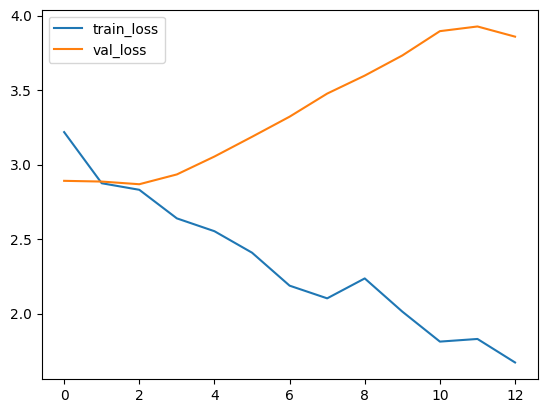

In [14]:
_ = log.plot()

In [15]:
model.partial_log_likelihood(*val).mean()

-2.8685894

In [16]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

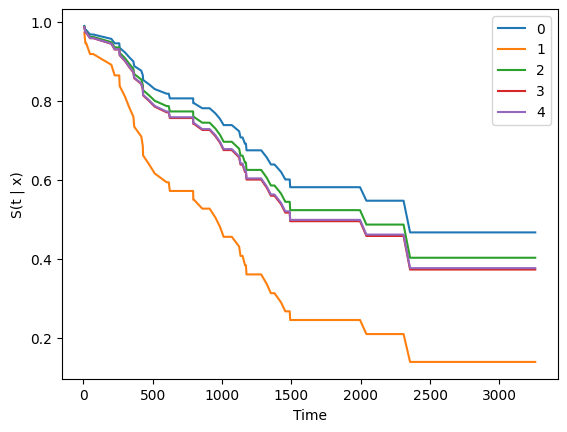

In [17]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [18]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()


0.6277372262773723